In [1]:
# necessary imports 
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import random

In [2]:
# optimizations
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
 
config = dict(
    IMAGE_PATH="../../../dataset/NIH_WHOLE_DATASET/nih-15-class/",
    SAVED_PATH_MOB="../saved-models/mobilenet_v3v1.pth",
    SAVED_PATH_SHFL="../saved-models/shuffle15v1.pth",
    SAVED_PATH_BEST="../saved-models/mobilenet_v3v1_best.pth",
    lr = 0.001,
    EPOCHS = 30,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 224,
    pin_memory = True,
    num_workers = 4,
    channels_last = False,
    gpu_id = 3,
    USE_AMP=True,
    SEED = 42
    )

device = torch.device(f"cuda:{config['gpu_id']}" if torch.cuda.is_available() else 'cpu')
print(device)
random.seed(config['SEED'])
np.random.seed(config['SEED'])
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])


transformations = {
    'general':transforms.Compose([
        torchvision.transforms.Resize((config['IMAGE_SIZE'])),
        torchvision.transforms.ToTensor()
    ]),
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

cuda:3


In [3]:
def plot_roc(fpr_tpr_auc): # name can be test train or validation
    plt.figure(figsize=(7,6))
    for i in range(15):
        fpr,tpr,aucc = fpr_tpr_auc[i]
        plt.plot(fpr,tpr,label = 'auc{:d}:{:.2f}'.format(i,aucc))
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.legend()
        plt.title('ROC')
    plt.show()

def evaluate(model,loader,name='test'):
    model.eval()
    correct = 0;samples =0
    fpr_tpr_auc = {}
    pre_prob = []
    lab = []
    predicted_labels = []

    with torch.no_grad():
        for idx,(x,y) in enumerate(loader):
            x = transformations['test'](x)
            x = x.to(device)
            y = y.to(device)
            # model = model.to(device)

            scores = model(x)
            predict_prob = F.softmax(scores)
            _,predictions = predict_prob.max(1)

            predictions = predictions.to('cpu')
            y = y.to('cpu')
            predict_prob = predict_prob.to('cpu')

            predicted_labels.extend(list(predictions.numpy()))
            pre_prob.extend(list(predict_prob.numpy()))
            lab.extend(list(y.numpy()))

            correct += (predictions == y).sum()
            samples += predictions.size(0)

            print('batches done : ',idx,end='\r')

        print('correct are {:.2f}'.format(correct/samples))

    #     fpr_tpr_auc[f'fpr_{name}'], fpr_tpr_auc[f'tpr_{name}'], _ = roc_curve(lab,pre_prob[:,1])
    #     fpr_tpr_auc[f'auc_{name}'] = auc(fpr_tpr_auc[f'fpr_{name}'],fpr_tpr_auc[f'tpr_{name}'])
    y_binarize = label_binarize(lab,classes=[i for i in range(15)])
    pre_prob = np.array(pre_prob)
    for i in range(15):
        fpr,tpr,_ = roc_curve(y_binarize[:,i],pre_prob[:,i])
        aucc = auc(fpr,tpr)
        fpr_tpr_auc[i] = [fpr,tpr,aucc]
        model.train()
    return fpr_tpr_auc

In [4]:
images = torchvision.datasets.ImageFolder(root=config['IMAGE_PATH'],transform=transformations['general'])
print(len(images))
train_data,validate_data,test_data = torch.utils.data.dataset.random_split(images,[120000,10000,11537])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])

print(images.class_to_idx)

141537
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'No Finding': 10, 'Nodule': 11, 'Pleural_Thickening': 12, 'Pneumonia': 13, 'Pneumothorax': 14}


# Mobilenet v3 -15 class

In [5]:
torchmodel = torchvision.models.mobilenet_v3_large(pretrained = True)
torchmodel.classifier[3] = nn.Linear(in_features=1280, out_features=15, bias=True)
# print(torchmodel)
torchmodel = torchmodel.to(device)

In [6]:
saved_model = torch.load(config['SAVED_PATH_MOB'])
torchmodel.load_state_dict(saved_model['model'])
torchmodel.eval()

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

/DATA/sharma59/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


correct are 0.46360


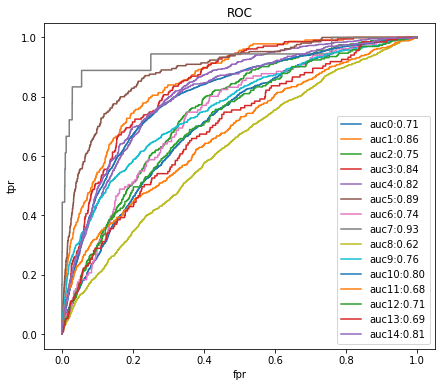

In [7]:
fta_test_mob = evaluate(torchmodel,test_loader,name='test')
plot_roc(fta_test_mob)

# shufflenet 15-class

In [9]:
torchmodel = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
torchmodel.fc = nn.Linear(in_features=1024, out_features=15, bias=True)
# print(torchmodel)
torchmodel = torchmodel.to(device)

In [10]:
saved_model = torch.load(config['SAVED_PATH_SHFL'])
print(torchmodel.load_state_dict(saved_model['model']))
torchmodel.eval()

<All keys matched successfully>


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

/DATA/sharma59/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/DATA/sharma59/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


correct are 0.47360


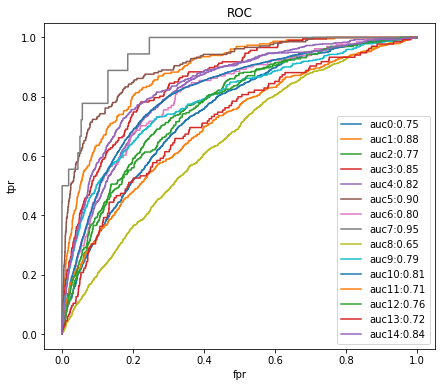

In [11]:
fta_test_mob = evaluate(torchmodel,test_loader,name='test')
plot_roc(fta_test_mob)